In [1]:
import squidpy as sq
import cellcharter as cc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os
import glob
import torch

/home/dpatravali/miniforge3/envs/resolvi-perturb-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/dpatravali/miniforge3/envs/resolvi-perturb-env/lib/python3.10/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/dpatravali/.local/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.war

NOTE: this only includes overlapping genes, not full gene panel due to the output of the scvi embeddings and clustering notebook

In [2]:
joint_path = '/mnt/sata1/Dhruv_Analysis_1/joint_cl13_armstrong_p14_ab_Xist_scvi_leiden.h5ad'

adata = sc.read(joint_path)

In [3]:
adata.obs["sample_id"] = adata.obs["infection"].astype(str) + "__" + adata.obs["batch"].astype(str)

In [4]:
adata.var_names

Index(['Acta2', 'Adam15', 'Adam17', 'Adam2', 'Adam23', 'Adam9', 'Adamdec1',
       'Adgre1', 'Aif1', 'Aldh1a1',
       ...
       'Vcam1', 'Vdr', 'Vim', 'Vps37b', 'Vtn', 'Vwf', 'Xcl1', 'Xcr1', 'Xist',
       'Zdhhc14'],
      dtype='object', length=315)

In [5]:
# create combined key (if you haven’t already)
adata.obs["sample_id"] = (
    adata.obs["infection"].astype(str) + "__" + adata.obs["batch"].astype(str)
)

# make categorical (required by squidpy for library_key)
adata.obs["sample_id"] = adata.obs["sample_id"].astype("category")

# (optional but good) also make infection/batch categorical
adata.obs["infection"] = adata.obs["infection"].astype("category")
adata.obs["batch"]     = adata.obs["batch"].astype("category")


100%|██████████| 4/4 [00:00<00:00, 21.57it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, 

Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 112.65it/s, nll=-25.4]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 80.39it/s, nll=-25.4] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.35it/s]


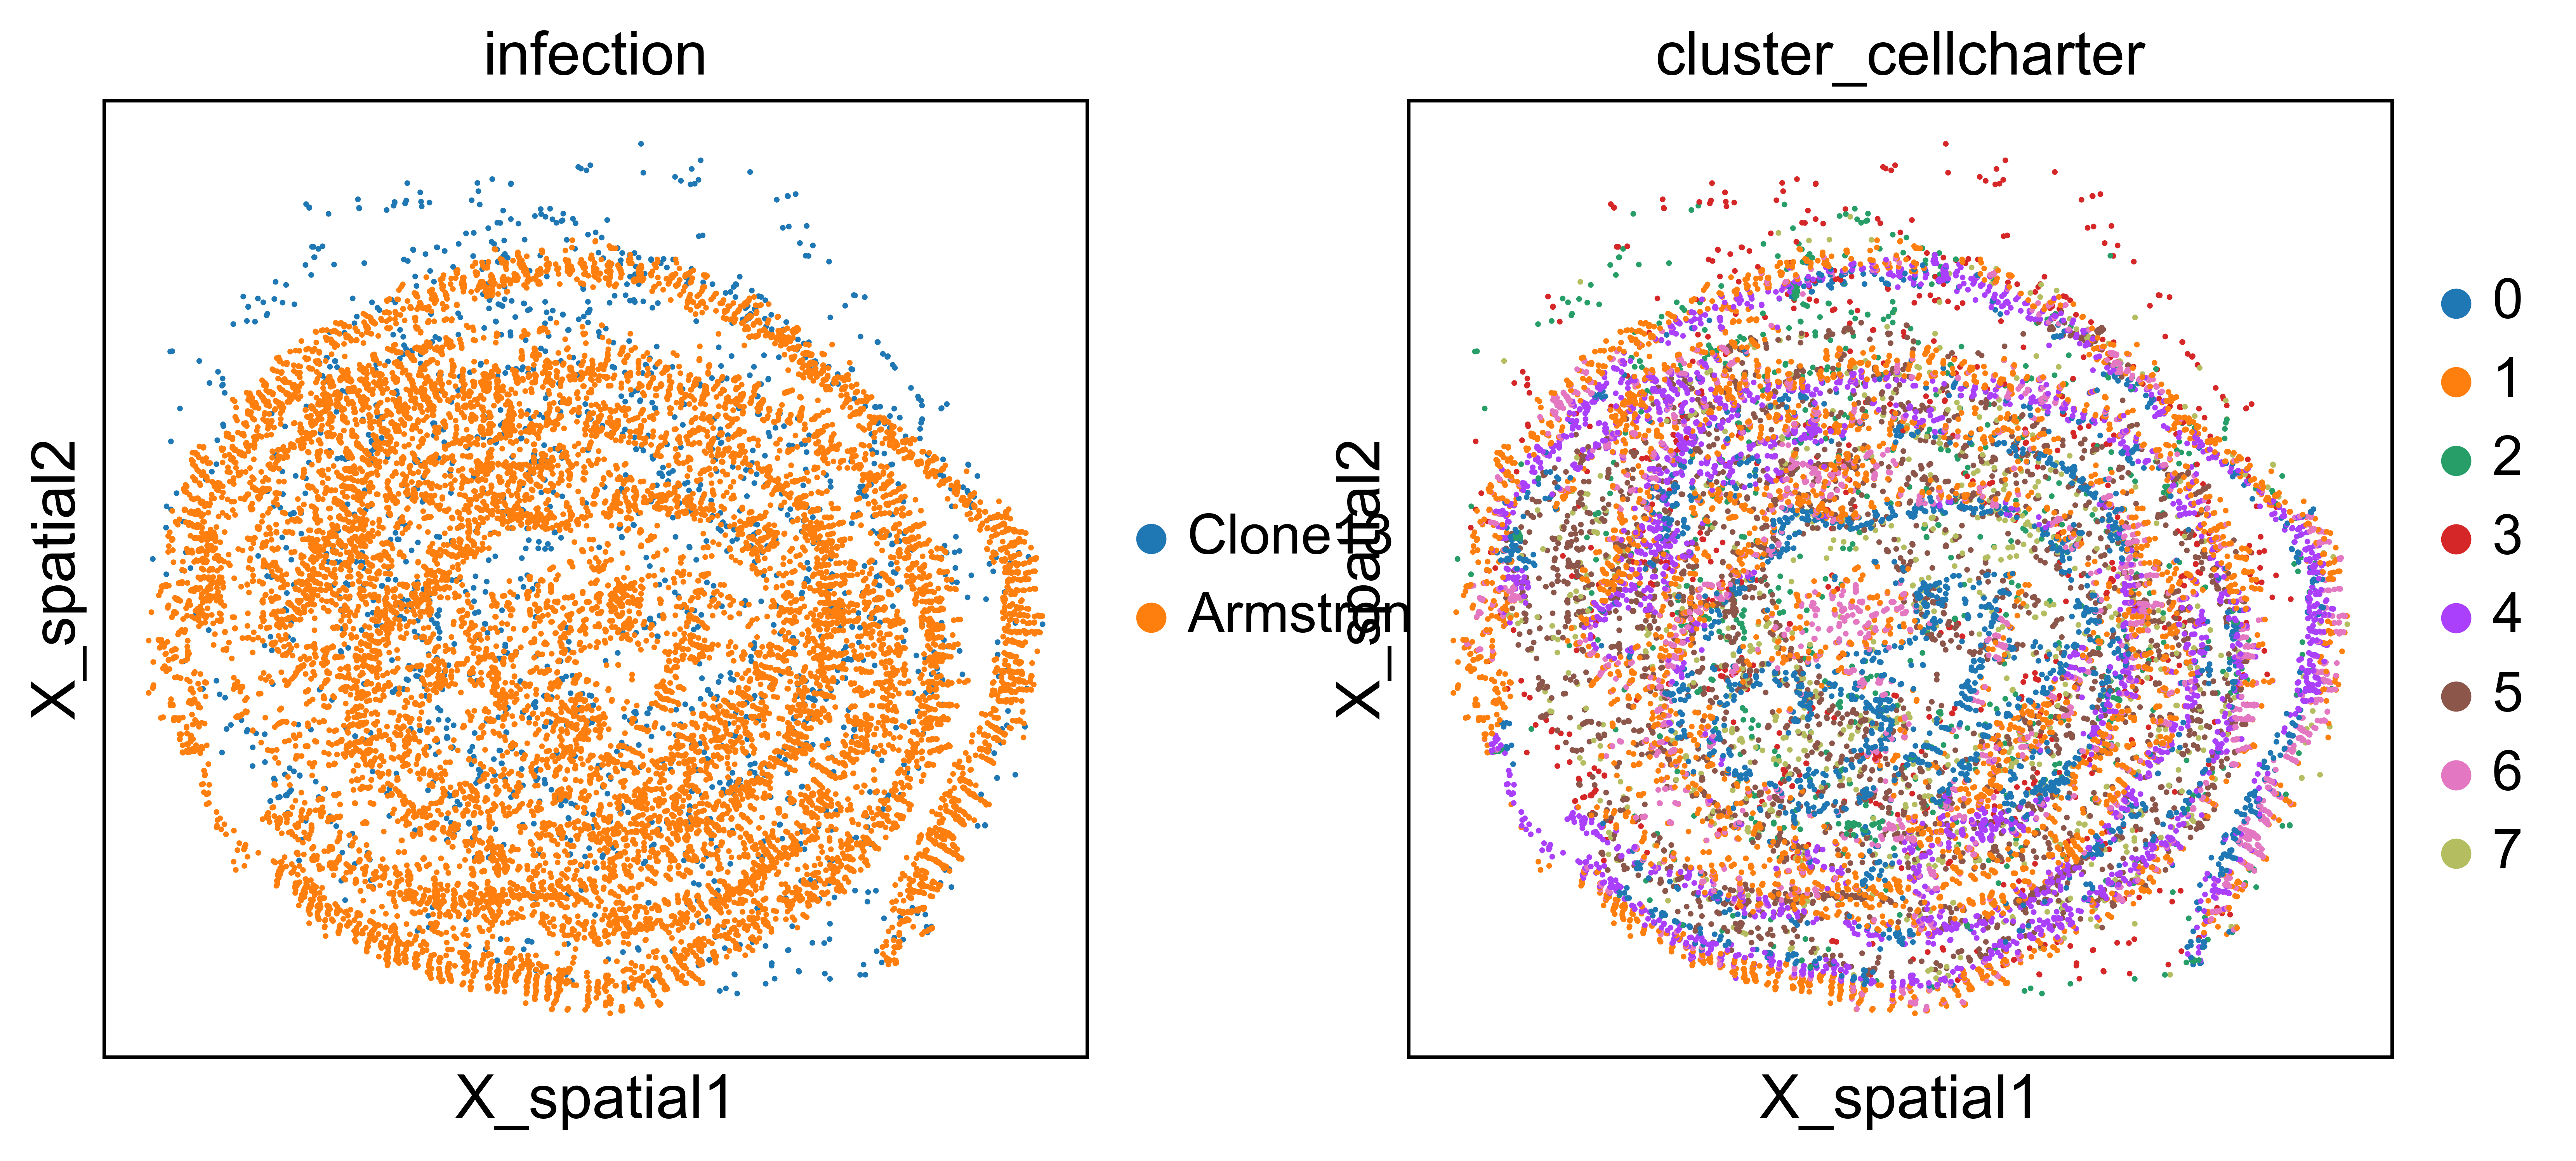

In [6]:

# compute and determine neighbors
sq.gr.spatial_neighbors(
    adata,
    library_key="sample_id",
    coord_type="generic",
    delaunay=True,
    spatial_key="X_spatial",
)

# aggregate neighbors
cc.gr.aggregate_neighbors(
    adata,
    n_layers=3,
    use_rep="X_scVI",
    out_key="X_cellcharter",
    sample_key="sample_id",
)

# autok = cc.tl.ClusterAutoK(
#     n_clusters=(1, 10), 
#     max_runs=10,
#     convergence_tol=0.001
# )

autok = cc.tl.Cluster(
    n_clusters=8
)

torch.set_float32_matmul_precision('medium')
# use autok to determine optimal number of clusters
autok.fit(adata, use_rep='X_cellcharter')

# predict cluster assignments
adata.obs['cluster_cellcharter'] = autok.predict(adata, use_rep='X_cellcharter')

sc.set_figure_params(dpi=400)
sc.pl.embedding(adata, basis = 'X_spatial', color = ['infection', 'cluster_cellcharter'])
